In [10]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [2]:
#Set dataset

datasetDirectory = ""

In [3]:
#Import raw JIRA dataset
rawData_JIRA_dealService = pd.read_csv('../data/01_raw/deal-service.csv')

#import
rawData_SVN_dealService = loadCommits('../data/01_raw/dealservice-dump.txt')

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [4]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [5]:
#Start timer
startTime = time.time() 

intermediateData_SVN_dealService = cleanCommitData(rawData_SVN_dealService)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_dealService.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_dealService.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_dealService.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_dealService.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 9.17812204360962 seconds


In [6]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


In [7]:
#Rename key to Issue key
#rawData_JIRA_academyMay = rawData_JIRA_academyMay.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_dealService = cleanJiraData(dataFrame = rawData_JIRA_dealService, cleanComments = True, commentAmount = 35)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_dealService.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_dealService.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_dealService.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_dealService.pkl")

1/4) Finished Cleaning Summaries after 0.18485212326049805 sec
2/4) Finished Cleaning Description after 0.7865664958953857 sec
3/4) Finished Cleaning Dates after 0.8022205829620361 sec
4/4) Finished Cleaning Comments after 2.0272841453552246 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [8]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [9]:
#Create JIRA corpus for dealService dataset
intermediateData_JIRA_dealServiceCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Summary)
intermediateData_JIRA_dealServiceCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Description)
intermediateData_JIRA_dealServiceCorpusComments = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Comments)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dealServiceCorpus = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dealServiceCorpusSummary,
                                                                             intermediateData_JIRA_dealServiceCorpusDescription,
                                                                             intermediateData_JIRA_dealServiceCorpusComments
                                                                            )]

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dealServiceCorpus, f)

Bigram corpora

In [10]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [11]:
#Create JIRA corpus for dealService dataset
intermediateData_JIRA_dealServiceCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Summary_2grams)
intermediateData_JIRA_dealServiceCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Description_2grams)
intermediateData_JIRA_dealServiceCorpusComments_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Comments_2grams)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dealServiceCorpus_2gram = [i+" "+j+" "+k  for i,j,k in zip(intermediateData_JIRA_dealServiceCorpusSummary_2grams,
                                                                             intermediateData_JIRA_dealServiceCorpusDescription_2grams,
                                                                             intermediateData_JIRA_dealServiceCorpusComments_2grams
                                                                                  )]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dealServiceCorpus_2gram, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [12]:
intermediateData_SVN_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dealService.pkl")

In [13]:
#Create corpus for log messages
intermediateData_SVNLogs_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs + intermediateData_SVN_dealService.Unit_names)
intermediateData_SVN_dealServiceCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs + intermediateData_SVN_dealService.Unit_names)
#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dealServiceCorpus, f)

with open('../data/02_intermediate/intermediateData_SVNUnitNames_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dealServiceCorpus, f)

with open('../data/02_intermediate/intermediateData_SVN_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dealServiceCorpus, f)
    
with open('../data/02_intermediate/intermediateData_SVN_dealServiceCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dealServiceCorpusAll, f)

bigram corpora

In [14]:
intermediateData_SVNLogs_dealServiceCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dealService.Logs_2grams)
intermediateData_SVNUnitNames_dealServiceCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dealService.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dealServiceCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dealServiceCorpus_2gram, f)

# 3. Preprocess Data

In [15]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_dealService.pkl")

intermediateData_SVN_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dealService.pkl")

intermediateData_JIRA_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl')
intermediateData_JIRA_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl')
#intermediateData_SVN_dealServiceCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpusAll.pkl')
#intermediateData_SVN_dealServiceCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpusModel.pkl')
intermediateData_SVN_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [16]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

#Create cartesian products JIRA x Commits
processedData_dealServiceCartesian = intermediateData_JIRA_dealService.merge(intermediateData_SVN_dealService, how='cross')
processedData_dealServiceCartesian.info()
processedData_dealServiceCartesian = processedData_dealServiceCartesian.drop(processedData_dealServiceCartesian[processedData_dealServiceCartesian.Jira_created_date > processedData_dealServiceCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_dealServiceCartesian.to_pickle(path= "../data/03_processed/processedData_dealServiceCartesian.pkl")



<class 'pandas.core.frame.DataFrame'>
Int64Index: 258635 entries, 0 to 258634
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Issue_key_jira              258635 non-null  object        
 1   Assignee                    213785 non-null  object        
 2   Jira_created_date           258635 non-null  datetime64[ns]
 3   Jira_updated_date           258635 non-null  datetime64[ns]
 4   Jira_resolved_date          218270 non-null  datetime64[ns]
 5   Summary                     258635 non-null  object        
 6   Summary_2grams              258635 non-null  object        
 7   Summary_3grams              258635 non-null  object        
 8   Description                 258635 non-null  object        
 9   Description_2grams          258635 non-null  object        
 10  Description_3grams          258635 non-null  object        
 11  Comments                    258635 non-

AttributeError: 'numpy.ndarray' object has no attribute 'is_valid'

## 3.1 Preprocess Data - Create Labels

In [17]:
#Create new dataFrames for the time features
processedData_dealServiceLabels = pd.DataFrame() 


#Create a column, which indicates which traces are valid.
processedData_dealServiceLabels["is_valid"] = processedData_dealServiceCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for dealService")

#Save intermediate results
processedData_dealServiceLabels.to_pickle(path= "../data/03_processed/processedData_dealServiceLabels.pkl")

processedData_dealServiceLabels.info()

Finished creating labels for dealService
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89233 entries, 1487 to 258634
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_valid  89233 non-null  bool 
dtypes: bool(1)
memory usage: 784.3 KB


In [18]:
#processedData_dealServiceLabels[processedData_dealServiceLabels.is_valid == True].count()
processedData_dealServiceLabels[processedData_dealServiceLabels.is_valid == True].count()

is_valid    420
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [19]:
#Create new dataFrames for the time features
processedData_dealServiceFeaturesTime = pd.DataFrame() 


#Calculate the time features for data Processing Dataset
processedData_dealServiceFeaturesTime['Creation_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_dealServiceFeaturesTime['Updated_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_dealServiceFeaturesTime['Resolved_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")

#Create a pickle file for all intermediate datasets
processedData_dealServiceFeaturesTime.to_pickle(path= "../data/03_processed/processedData_dealServiceFeaturesTime.pkl")

Finished data Processing


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [20]:
#Create new dataFrames for the Stakeholder features
processedData_dealServiceFeaturesStakeholder = pd.DataFrame() 

processedData_dealServiceFeaturesStakeholder['Assignee_is_commiter'] = processedData_dealServiceCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished dealService")

#Create a pickle file for all intermediate datasets
processedData_dealServiceFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl")


Finished dealService


In [21]:
processedData_dealServiceFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89233 entries, 1487 to 258634
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Assignee_is_commiter  76693 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 dealService - Cosine Similarity UniGrams

In [22]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [23]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       dealService              #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_dealServiceCountVectorizer = CountVectorizer()
processedData_SVN_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealServiceCorpus)

processedData_SVNLogs_dealServiceCountVectorizer = CountVectorizer()
processedData_SVNLogs_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_dealServiceCountVectorizer, intermediateData_SVNLogs_dealServiceCorpus)

processedData_SVNUnitNames_dealServiceCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_dealServiceCountVectorizer, intermediateData_SVNUnitNames_dealServiceCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRA_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpus)

processedData_JIRASummaries_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRASummaries_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusSummary)

processedData_JIRADescriptions_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusDescription)

processedData_JIRAComments_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRAComments_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_dealServiceCountVectorizer_2gram, intermediateData_SVNLogs_dealServiceCorpus_2gram)

processedData_SVNUnitNames_dealServiceCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, intermediateData_SVNUnitNames_dealServiceCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpus_2gram)

processedData_JIRASummaries_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusSummary_2grams)

processedData_JIRADescriptions_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusDescription_2grams)

processedData_JIRAComments_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRAComments_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusComments_2grams)




#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [24]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 5 minutes and 7.45426869392395 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 47.17534613609314 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 25.189353227615356 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 47.32737469673157 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 39.080777645111084 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 0.03845024108886719 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 20.528594732284546 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 5 minutes and 17.80805230140686 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 14.296204328536987 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 23.25654435157776 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 8.73307490348816 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery["vsm_comments_unitnames_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 36.285478353500366 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery["vsm_comments_unitnames_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 1.3787086009979248 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsCommentsAsQuery["vsm_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 28.286805868148804 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

In [38]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsLogsAsQuery["vsm_comments_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 18.10190200805664 seconds


#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram["vsm_comments_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 48.930150508880615 seconds


#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

In [40]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram["vsm_comments_comments_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dealServiceCountVectorizer_2gram, processedData_JIRAComments_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 20.082991123199463 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 44.73593521118164 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [42]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 4.07165265083313 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery["vsm_unitnames_comments_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 46.19073271751404 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [44]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery["vsm_unitnames_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 21.161534309387207 seconds


In [45]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [46]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 51.4496693611145 seconds


In [47]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [48]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 53 minutes and 56.870359897613525 seconds


In [49]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [50]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 42.126174211502075 seconds


In [51]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 14.52494502067566 seconds


In [53]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 3.8073415756225586 seconds


In [55]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 48.51523017883301 seconds


In [57]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [58]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnCommentsSvnAsQuery["vsm_svn_comments_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnCommentsSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 44.62076997756958 seconds


In [59]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

In [60]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery["vsm_svn_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 36.02896761894226 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [61]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 2.5970616340637207 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [62]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dealServiceCountVectorizer_2gram, processedData_JIRA_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 30.555123805999756 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer_2gram, processedData_SVNLogs_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 28.31280779838562 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [64]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer_2gram, processedData_JIRA_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 31.310052394866943 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 58.085158586502075 seconds


#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 59.97384858131409 seconds


#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dealServiceCountVectorizer_2gram, processedData_JIRADescriptions_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

Finished creating 'VSM Bigrams' after 5 minutes and 13.67255425453186 seconds


#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [68]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_dealServiceCountVectorizer_2gram, processedData_JIRASummaries_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 54.002402544021606 seconds


## 3.6 Document Statistics

### dealService

In [69]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_dealServiceFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_dealServiceFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_dealServiceFeaturesTotalWordCount["total_term_count_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_dealServiceFeaturesTotalWordCount["total_term_count_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_dealServiceFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")

processedData_JIRA_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 0 minutes and 17.35699486732483 seconds


## 3.7 Query Quality

In [70]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [71]:
#Read datasets from disk
processedData_dealServiceCartesian = pd.read_pickle(r"../data/03_processed/processedData_dealServiceCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_dealServiceCountVectorizer = CountVectorizer()
processedData_SVN_dealServiceTF_IDF = createFittedTF_IDF(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealServiceCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRA_dealServiceTF_IDF = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpus)

#Determine document counts
intermediateData_JIRA_dealService_documentCount = len(intermediateData_JIRA_dealService.index)
intermediateData_SVN_dealService_documentCount = len(intermediateData_SVN_dealService.index)



#### IDF Scores (SVN as Query)

In [72]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                processedData_SVN_dealServiceTF_IDF),axis=1)

processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 28 minutes and 32.79408144950867 seconds


#### IDF Scores (SVNLogs as Query)

In [73]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                processedData_SVNLogs_dealServiceCountTF_IDF),axis=1)

processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 38.72721982002258 seconds


#### IDF Scores (SVNUnitNames as Query

In [74]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                processedData_SVNLogs_dealServiceCountTF_IDF),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 39.77573561668396 seconds


##### IDF Scores (JIRA as Query)

In [75]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRA_dealServiceTF_IDF),axis=1)

processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 92 minutes and 48.95662188529968 seconds


##### IDF Scores (JIRA Summaries as Query)

In [76]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRASummaries_dealServiceCountTF_IDF),axis=1)

processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 3 minutes and 45.127768993377686 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [77]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountTF_IDF),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 17 minutes and 4.594225168228149 seconds


##### IDF Scores (JIRA Comments as Query)

In [78]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Comments, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountTF_IDF),axis=1)

processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_avgIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_maxIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_devIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraCommentsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 33 minutes and 25.290278434753418 seconds


#### ICTF Scores (SVN as query)

In [79]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 20 minutes and 4.4400341510772705 seconds


#### ICTF Scores (SVNLogs as query)

In [80]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)
##
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 14.88181471824646 seconds


#### ICTF Scores (SVNUnitNames as query)

In [81]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)
##
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 19.744380474090576 seconds


#### ICTF Scores (JIRA as query)

In [82]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 49.15820527076721 seconds


#### ICTF Scores (JIRA Summaries as query)

In [83]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 16.560428857803345 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [84]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 22.565612316131592 seconds


#### ICTF Scores (JIRA Comments as query)

In [85]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_avgICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraCommentsAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_maxICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraCommentsAsQuery_ICTF), axis=1)
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_devICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraCommentsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 36.422266483306885 seconds


#### Entropy (SVN as query)

In [86]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Commit_natural_text),axis=1)

processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 71 minutes and 30.406294345855713 seconds


#### Entropy (SVNLogs as query)

In [87]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Logs),axis=1)
##
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 4 minutes and 16.636083364486694 seconds


#### Entropy (SVNUnitNames as query)

In [88]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Unit_names),axis=1)
##
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 47 minutes and 27.526021718978882 seconds


#### Entropy (JIRA as query)

In [89]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Jira_natural_text),axis=1)
##
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 52 minutes and 52.43811345100403 seconds


#### Entropy (JIRA Summaries as query)

In [90]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Summary),axis=1)
##
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 58.05627369880676 seconds


#### Entropy (JIRA Descriptions as query)

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Description),axis=1)
##
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 23.865477085113525 seconds


#### Entropy (JIRA Comments as query)

In [92]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Comments),axis=1)
##
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_medEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_devEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 20 minutes and 25.814197301864624 seconds


##### Query Scope (SVN as query)

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_dealService.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 5 minutes and 56.84695649147034 seconds


##### Query Scope (SVNLogs as query)

In [94]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_dealService.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.65317344665527 seconds


##### Query Scope (SVNUnitNames as query)

In [95]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_dealService.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 47.93760299682617 seconds


##### Query Scope (JIRA as query)

In [96]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_dealService.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 35.85256242752075 seconds


##### Query Scope (JIRA Summaries as query)

In [97]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_dealService.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 17.89712142944336 seconds


##### Query Scope (JIRA Descriptions as query)

In [98]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_dealService.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 56.1099636554718 seconds


##### Query Scope (JIRA Comments as query)

In [99]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesQueryScope["JiraCommentsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Comments, 
                                                                                                                intermediateData_JIRA_dealService.Comments),axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 21.79303526878357 seconds


#### Kullback-Leiber divergence (SVN as query)

In [100]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesSCS["SvnAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 19.22192692756653 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [101]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.938369035720825 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [102]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 18.892534971237183 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [103]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesSCS["JiraAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 24.89457607269287 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [104]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.886245012283325 seconds


In [105]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [106]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 6.50683331489563 seconds


In [107]:
##### Kullback-Leiber divergence (JIRA Comments as query)

In [108]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesSCS["JiraCommentsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 13.457808494567871 seconds


#### SCQ (SVN as Query)

In [109]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_dealService.Commit_natural_text,
                                                                                                                                         processedData_SVN_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVN_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 6.968505144119263 seconds


#### SCQ (SVNLogs as Query)

In [110]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_dealService.Logs,
                                                                                                                                         processedData_SVNLogs_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVNLogs_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 5.513383865356445 seconds


#### SCQ (SVNUnitNames as Query)

In [111]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_dealService.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.62586808204651 seconds


#### SCQ (JIRA as Query)

In [112]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_dealService.Jira_natural_text,
                                                                                                                                         processedData_JIRA_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRA_dealServiceTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 5.339867115020752 seconds


#### SCQ (JIRA Summaries as Query)

In [113]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_dealService.Summary,
                                                                                                                                         processedData_JIRASummaries_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.475221395492554 seconds


#### SCQ (JIRA Descriptions as Query)

In [114]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_dealService.Description,
                                                                                                                                         processedData_JIRADescriptions_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 57.394967794418335 seconds


#### SCQ (JIRA Comments as Query)

In [115]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Comments, intermediateData_JIRA_dealService.Comments,
                                                                                                                                         processedData_JIRAComments_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRAComments_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraCommentsAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 31.504469633102417 seconds


#### PMI (SVN as query)

In [116]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealService.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Commit_natural_text)

#Create new dataFrame
processedData_SVN_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Commit_natural_text),axis=1)

processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_dealServiceFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 53 minutes and 22.118372440338135 seconds


#### PMI (SVNLogs as query)

In [117]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_dealServiceCountVectorizer, intermediateData_SVN_dealService.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Logs)

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Logs),axis=1)

processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_dealServiceFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 15 minutes and 34.60083270072937 seconds


#### PMI (SVNUnitNames as query)

In [118]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_dealServiceCountVectorizer, intermediateData_SVN_dealService.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Unit_names),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_dealServiceFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 22 minutes and 50.996848821640015 seconds


#### PMI (JIRA as query)

In [119]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Jira_natural_text),axis=1)

processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_dealServiceFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 31 minutes and 6.664822340011597 seconds


#### PMI (JIRA Summaries as query)

In [120]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Summary)

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Summary),axis=1)

processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_dealServiceFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 1 minutes and 43.11443543434143 seconds


#### PMI (JIRA Descriptions as query)

In [121]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Description)

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Description),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_dealServiceFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 5 minutes and 52.282089710235596 seconds


#### PMI (JIRA Comments as query)

In [122]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRAComments_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRAComments_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Comments)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Comments)

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Comments, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Comments),axis=1)

processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_avgPMI"] = processedData_JIRAComments_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraCommentsAsQuery_PMI), axis=1)
processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentssAsQuery_maxPMI"] = processedData_JIRAComments_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraCommentsAsQuery_PMI), axis=1)



processedData_JIRAComments_dealServiceFeaturesPMI.drop('JiraCommentsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 12 minutes and 5.567742109298706 seconds


In [11]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [12]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_dealServiceFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesTime.pkl')
processedData_dealServiceFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl')
processedData_dealService_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl')

processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery.pkl')
processedData_dealService_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery.pkl')

processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.pkl')
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")
processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_dealServiceFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesQueryQuality.pkl')
processedData_SVN_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl')
processedData_SVNLogs_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl')
processedData_JIRA_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl')
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl')
processedData_JIRAComments_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl')


processedData_SVN_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesICTF.pkl')
processedData_SVNLogs_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl')
processedData_JIRA_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl')
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl')
processedData_JIRAComments_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl')


processedData_SVN_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesEntropy.pkl')
processedData_SVNLogs_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl')
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl')
processedData_JIRA_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl')
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl')
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl')
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl')


processedData_SVN_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesQueryScope.pkl')
processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl')
processedData_JIRA_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl')
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl')
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl')


processedData_SVN_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesSCS.pkl')
processedData_SVNLogs_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl')
processedData_JIRA_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl')
processedData_JIRAComments_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl')


processedData_SVN_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesSCQ.pkl')
processedData_SVNLogs_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl')
processedData_JIRA_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl')
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl')


processedData_SVN_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesPMI.pkl')
processedData_SVNLogs_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl')
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl')
processedData_JIRA_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl')
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl')
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl')
processedData_JIRAComments_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_dealServiceFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_dealServiceFeaturesTime_normalized = normalizeData(processedData_dealServiceFeaturesTime)
processedData_dealServiceFeaturesStakeholder_normalized = normalizeData(processedData_dealServiceFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmLogsJiraAsQuery)
processedData_dealService_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_dealService_features_VsmLogsLogAsQuery)
processedData_dealService_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesJiraAsQuery)
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery)
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery)
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryLogsSummaryAsQuery)
processedData_dealService_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryLogsLogsAsQuery)
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmDescriptionLogsAsQuery)
processedData_dealService_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmCommentsCommentsAsQuery)
processedData_dealService_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmCommentsLogsAsQuery)

processedData_dealService_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnJiraJiraAsQuery)
processedData_dealService_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnJiraSvnAsQuery)
processedData_dealService_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnSummarySvnAsQuery)
processedData_dealService_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnSummarySummaryAsQuery)
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnDescriptionSvnAsQuery)
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnCommentsSvnAsQuery)
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmLogsJiraAsQuery_2gram)
processedData_dealService_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmLogsLogAsQuery_2gram)
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram)
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram)
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmCommentsLogsAsQuery_2gram)
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesUniqueWordCount)
processedData_SVN_dealServiceFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_dealServiceFeaturesUniqueWordCount)
processedData_JIRA_dealServiceFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesTotalWordCount)
processedData_SVN_dealServiceFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_dealServiceFeaturesTotalWordCount)
processedData_JIRA_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesOverlapPercentage)
processedData_SVN_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_dealServiceFeaturesOverlapPercentage)
processedData_UNION_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_dealServiceFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVN_dealServiceFeaturesIDF)
processedData_SVNLogs_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesIDF)
processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesIDF)
processedData_JIRA_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesIDF)
processedData_JIRASummaries_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesIDF)
processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesIDF)
processedData_JIRAComments_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesIDF)

processedData_SVN_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVN_dealServiceFeaturesICTF)
processedData_SVNLogs_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesICTF)
processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesICTF)
processedData_JIRA_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesICTF)
processedData_JIRASummaries_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesICTF)
processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesICTF)
processedData_JIRAComments_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesICTF)

processedData_SVN_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVN_dealServiceFeaturesEntropy)
processedData_SVNLogs_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesEntropy)
processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesEntropy)
processedData_JIRA_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesEntropy)
processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesEntropy)
processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesEntropy)
processedData_JIRAComments_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesEntropy)

processedData_SVN_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVN_dealServiceFeaturesQueryScope)
processedData_SVNLogs_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesQueryScope)
processedData_SVNUnitNames_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesQueryScope)
processedData_JIRA_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesQueryScope)
processedData_JIRASummaries_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesQueryScope)
processedData_JIRADescriptions_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesQueryScope)
processedData_JIRAComments_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesQueryScope)

processedData_SVN_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVN_dealServiceFeaturesSCS)
processedData_SVNLogs_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesSCS)
processedData_SVNUnitNames_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesSCS)
processedData_JIRA_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesSCS)
processedData_JIRASummaries_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesSCS)
processedData_JIRADescriptions_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesSCS)
processedData_JIRAComments_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesSCS)

processedData_SVN_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVN_dealServiceFeaturesSCQ)
processedData_SVNLogs_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesSCQ)
processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesSCQ)
processedData_JIRA_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesSCQ)
processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesSCQ)
processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesSCQ)
processedData_JIRAComments_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesSCQ)

processedData_SVN_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVN_dealServiceFeaturesPMI)
processedData_SVNLogs_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesPMI)
processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesPMI)
processedData_JIRA_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesPMI)
processedData_JIRASummaries_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesPMI)
processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesPMI)
processedData_JIRAComments_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesPMI)


## 3.8 Preprocess Data - Load and transform feature families needed for training

In [13]:

#Merge features into 1 dataframe
processedData_dealServiceFeatures = pd.concat([processedData_dealServiceFeaturesTime_normalized,
                                                  processedData_dealServiceFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_dealService_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmDescriptionLogsAsQuery_normalized,
                                                  processedData_dealService_features_VsmCommentsCommentsAsQuery_normalized,
                                                  processedData_dealService_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_dealService_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnCommentsSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dealServiceFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_dealServiceFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_dealServiceFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_dealServiceFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_dealServiceFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_dealServiceFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_dealServiceFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRA_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRAComments_dealServiceFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCS_normalized,
                                                  processedData_SVNLogs_dealServiceFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRA_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRAComments_dealServiceFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dealServiceFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_dealServiceFeatures = processedData_dealServiceFeatures.fillna(0)

#Saving feature names for later use
processedData_dealServiceFeatureNames = list(processedData_dealServiceFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dealServiceFeatures = np.array(processedData_dealServiceFeatures)

#Load labels
processedData_dealServiceLabels = pd.read_pickle(r'../data/03_processed/processedData_dealServiceLabels.pkl')
processedData_dealServiceLabels = np.array(processedData_dealServiceLabels["is_valid"])


In [20]:
#Load Process-Related Features
processedData_dealServiceFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesTime.pkl')
processedData_dealServiceFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl')
processedData_dealService_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')

#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")
processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_dealServiceFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesQueryQuality.pkl')
processedData_SVN_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl')
processedData_SVNLogs_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl')
processedData_JIRA_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl')
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl')
processedData_JIRAComments_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl')

processedData_SVNLogs_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl')
processedData_JIRA_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl')
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl')
processedData_JIRAComments_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl')


processedData_SVNLogs_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl')
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl')
processedData_JIRA_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl')
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl')
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl')
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl')


processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl')
processedData_JIRA_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl')
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl')
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl')


processedData_SVNLogs_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl')
processedData_JIRA_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl')
processedData_JIRAComments_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl')

processedData_SVNLogs_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl')
processedData_JIRA_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl')
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl')


processedData_SVNLogs_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl')
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl')
processedData_JIRA_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl')
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl')
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl')
processedData_JIRAComments_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl')

#Merge features into 1 dataframe
processedData_dealServiceFeatures = pd.concat([processedData_dealServiceFeaturesTime,
                                                  processedData_dealServiceFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_dealService_features_VsmLogsJiraAsQuery,
                                                  processedData_dealService_features_VsmLogsLogAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_dealService_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmDescriptionLogsAsQuery,
                                                  processedData_dealService_features_VsmCommentsCommentsAsQuery,
                                                  processedData_dealService_features_VsmCommentsLogsAsQuery,
                                                 # processedData_dealService_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_dealService_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_dealService_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_dealService_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_dealService_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmSvnCommentsSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnCommentsCommentsAsQuery,
    
                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dealServiceFeaturesUniqueWordCount,
                                                  processedData_SVN_dealServiceFeaturesUniqueWordCount,
                                                  processedData_JIRA_dealServiceFeaturesTotalWordCount,
                                                  processedData_SVN_dealServiceFeaturesTotalWordCount,
                                                  processedData_JIRA_dealServiceFeaturesOverlapPercentage,
                                                  processedData_SVN_dealServiceFeaturesOverlapPercentage,
                                                  processedData_UNION_dealServiceFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesQueryScope,
                                                  processedData_SVNLogs_dealServiceFeaturesQueryScope,
                                                  processedData_SVNUnitNames_dealServiceFeaturesQueryScope,
                                                  processedData_JIRA_dealServiceFeaturesQueryScope,
                                                  processedData_JIRASummaries_dealServiceFeaturesQueryScope,
                                                  processedData_JIRADescriptions_dealServiceFeaturesQueryScope,
                                                  processedData_JIRAComments_dealServiceFeaturesQueryScope,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCS,
                                                  processedData_SVNLogs_dealServiceFeaturesSCS,
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCS,
                                                  processedData_JIRA_dealServiceFeaturesSCS,
                                                  processedData_JIRASummaries_dealServiceFeaturesSCS,
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCS,
                                                  processedData_JIRAComments_dealServiceFeaturesSCS,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_dealServiceFeatures = processedData_dealServiceFeatures.fillna(0)

#Saving feature names for later use
processedData_dealServiceFeatureNames = list(processedData_dealServiceFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dealServiceFeatures = np.array(processedData_dealServiceFeatures)

#Load labels
processedData_dealServiceLabels = pd.read_pickle(r'../data/03_processed/processedData_dealServiceLabels.pkl')
processedData_dealServiceLabels = np.array(processedData_dealServiceLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [21]:
features = processedData_dealServiceFeatures
labels = processedData_dealServiceLabels

In [22]:
len(processedData_dealServiceLabels)

89233

In [24]:
processedData_dealServiceFeatureNames

['Creation_commit_date_dif',
 'Updated_commit_date_dif',
 'Resolved_commit_date_dif',
 'Assignee_is_commiter',
 'vsm_logs_jira_as_query',
 'vsm_logs_log_as_query',
 'vsm_unit_names_jira_as_query',
 'vsm_unit_names_log_as_query',
 'vsm_unitnames_comments_comments_as_query',
 'vsm_unitnames_comments_unitnames_as_query',
 'vsm_unitnames_description_description_as_query',
 'vsm_unitnames_description_unitnames_as_query',
 'vsm_summary_logs_summary_as_query',
 'vsm_summary_logs_logs_as_query',
 'vsm_summary_unitNames_summary_as_query',
 'vsm_summary_unitNames_summary_as_query',
 'vsm_description_description_as_query',
 'vsm_description_log_as_query',
 'vsm_comments_comments_as_query',
 'vsm_comments_log_as_query',
 'vsm_svn_jira_jira_as_query',
 'vsm_svn_jira_svn_as_query',
 'vsm_svn_summary_svn_as_query',
 'vsm_svn_summary_summary_as_query',
 'vsm_svn_description_svn_as_query',
 'vsm_svn_description_description_as_query',
 'vsm_svn_comments_svn_as_query',
 'vsm_svn_comments_comments_as_quer

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [18]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 71056, True: 330})


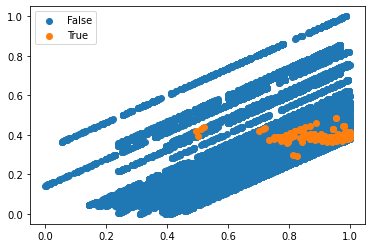

Counter({False: 14210, True: 7105})


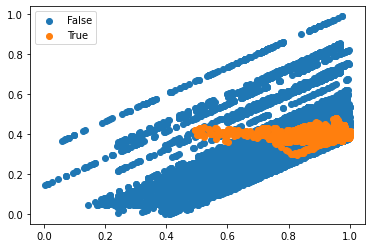

In [131]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over),('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.994957        0.5  0.622222  0.554455  0.59322  0.520446   

   Average Precision  
0           0.313016  

--------------------------------------------------------------------


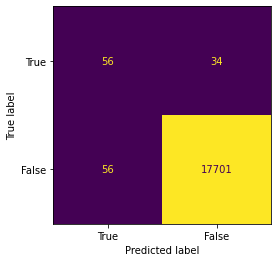

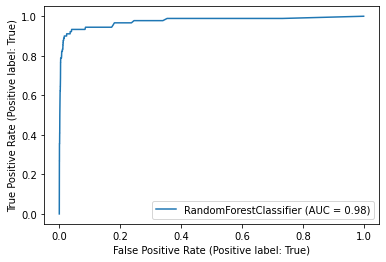

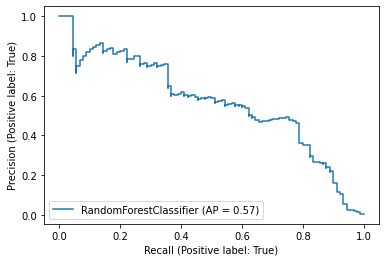

In [132]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_dealServiceFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

In [ ]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.995069   0.508475  0.666667  0.576923  0.627615  0.533808   

   Average Precision  
0           0.340664  

--------------------------------------------------------------------


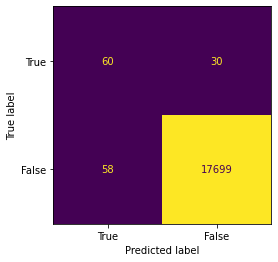

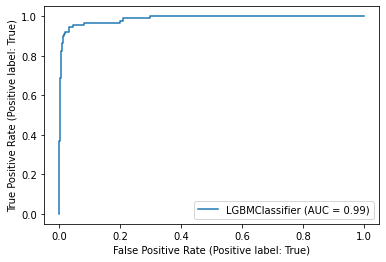

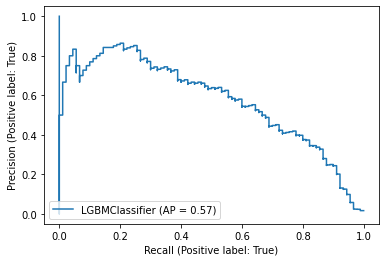

In [133]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

In [ ]:
for i in range(10):

# Model - Pipeline for GXBoost

In [134]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=15,shuffle=True)

# define search space
space = dict()
space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

KeyboardInterrupt: 

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

for i in range(25):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring=fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)



    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8471.333 seconds
Cross-validation score: 0.7833620933188874
Test score: 0.7072368421052632
Best Hyperparameters: {'classifier__min_child_weight': 7, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.9}
0.007280717
0.041686777
0.027852166
0.016497051
0.0097696
0.008066642
0.0072750985
0.0058377245
0.009053997
0.0052577625
0.0
0.0008380786
0.01325456
0.015686767
0.008522397
1.23353075e-05
0.0042417995
0.0
0.0039154734
0.006982486
0.019714026
0.019385207
0.0018829379
0.016075797
0.0071822857
0.0055115162
0.0054344647
0.012059351
0.005032682
0.0065225535
0.016567206
0.0025064505
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:36:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8487.585 seconds
Cross-validation score: 0.7713465721923385
Test score: 0.8390410958904111
Best Hyperparameters: {'classifier__min_child_weight': 5, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.7}
0.008659615
0.027166463
0.019998204
0.01599541
0.012194455
0.006677474
0.008719269
0.0105691925
0.005321285
0.003933833
0.0058335057
0.0061221616
0.007665669
0.010816731
0.0058671813
0.010296229
0.0031497402
0.0
0.0033860877
0.0032017056
0.018626852
0.023607137
0.0043178746
0.007835155
0.0054748273
0.00466907
0.0035874234
0.007808039
0.010245838
0.0
0.0076840003
0.008172436
0.00

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:05:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8905.164 seconds
Cross-validation score: 0.7888632196344991
Test score: 0.7730263157894737
Best Hyperparameters: {'classifier__min_child_weight': 4, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.5}
0.009267083
0.030386182
0.024932817
0.015979929
0.014383674
0.005627799
0.0024471704
0.009954823
0.006700904
0.0035406773
0.0033662103
0.006689563
0.01011042
0.009662398
0.008000495
0.011350679
0.0058014644
0.0
0.0039021382
0.0026939765
0.018405084
0.026484935
0.0045649293
0.005641298
0.0070522283
0.003145235
0.0069024996
0.005225219
0.0070872344
0.00816151
0.009409502
0.003885

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:31:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8778.735 seconds
Cross-validation score: 0.792540098301723
Test score: 0.75
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.8}
0.009911005
0.020556346
0.020919744
0.012127352
0.008803631
0.005405917
0.005710495
0.0060160737
0.0041575036
0.0049362876
0.0044472185
0.0048464173
0.0065203183
0.010626481
0.012673164
0.007977356
0.004096777
0.0
0.0034917109
0.004362802
0.0146500645
0.027261578
0.0068282667
0.005931465
0.0032619855
0.006950049
0.0028810445
0.009333834
0.005634864
0.011239546
0.01394568
0.006381712
0.00523536

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:57:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8782.198 seconds
Cross-validation score: 0.7948640499193699
Test score: 0.7922535211267605
Best Hyperparameters: {'classifier__min_child_weight': 2, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.8}
0.007938858
0.02728556
0.021699
0.019632893
0.008276821
0.004383785
0.006262849
0.0063729235
0.006221864
0.0063332017
0.0016690494
0.008996018
0.010703477
0.01090881
0.010421402
0.008261508
0.0034632266
0.0
0.0055566835
0.004219075
0.014707587
0.022475082
0.0051948708
0.014616059
0.005119604
0.0058341026
0.0028383685
0.00885157
0.011222005
0.008821832
0.0121699665
0.0043460433


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8849.157 seconds
Cross-validation score: 0.8019391457514597
Test score: 0.7203389830508474
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 0.5}
0.008120919
0.023514811
0.018032162
0.017383799
0.008927863
0.005672109
0.0053574364
0.005429776
0.005449633
0.005608084
0.015621999
0.004046272
0.008642891
0.0058761686
0.005289851
0.0051340126
0.00545163
0.0035363666
0.006747632
0.00352791
0.0151685765
0.013810962
0.0042875037
0.006549168
0.004191674
0.0083327945
0.006688347
0.0070507512
0.008058984
0.010191552
0.009225887
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 9052.973 seconds
Cross-validation score: 0.7931839833283132
Test score: 0.7291666666666666
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.35, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.5}
0.008284535
0.035476897
0.02491553
0.01811944
0.017181536
0.0055334577
0.0026817282
0.0049653645
0.0073106773
0.018058864
0.00070555875
0.0010075531
0.012680965
0.009899891
0.008143806
0.00569666
0.0032231298
0.0
0.008880161
0.0047936053
0.035560165
0.017545352
0.007547204
0.009273629
0.0011422806
0.0041447477
0.005030844
0.011074738
0.0137063945
0.0
0.015168367
0.0062723
0.006

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_enco

[18:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 9555.235 seconds
Cross-validation score: 0.7758640096480294
Test score: 0.7954545454545454
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1.0}
0.010662721
0.0334784
0.025855303
0.01855153
0.01557516
0.0052173035
0.0036888137
0.0069871377
0.0041657262
0.0083979815
0.011509899
0.0043396973
0.012709492
0.013545602
0.00847265
0.0
0.004852821
0.0
0.003561966
0.0035012064
0.021724613
0.03039302
0.005345357
0.010553884
0.010349866
0.0022486884
0.0034232994
0.004641242
0.005657762
0.009200083
0.006920764
0.007038082
0.00461855

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8701.661 seconds
Cross-validation score: 0.783932590006719
Test score: 0.76171875
Best Hyperparameters: {'classifier__min_child_weight': 4, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.35, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.7}
0.011269675
0.029801797
0.02574557
0.014747313
0.017809259
0.006181701
0.0057095285
0.004752855
0.0036842944
0.0046562925
0.005374431
0.0007868106
0.007973659
0.010414925
0.006153122
0.009378512
0.00200522
0.0
0.0034910596
0.0027774938
0.022358058
0.014212754
0.0030105903
0.010183511
0.0035900832
0.0024995392
0.011707173
0.009117629
0.0085839275
0.0
0.022764785
0.0
0.0097674215
0.0059144

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 8317.616 seconds
Cross-validation score: 0.7797773688077398
Test score: 0.8079268292682927
Best Hyperparameters: {'classifier__min_child_weight': 2, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.45, 'classifier__gamma': 0.4, 'classifier__colsample_bytree': 0.6}
0.009758768
0.025759475
0.02778052
0.014424488
0.011993156
0.0062806117
0.008311411
0.011548687
0.008090448
0.003054337
0.0010921025
0.0070762835
0.006543261
0.009955922
0.015955992
0.004376853
0.004629742
0.024283566
0.00510208
0.004564748
0.012032983
0.024015214
0.004828665
0.006929593
0.0024970404
0.007994252
0.0028304402
0.007585186
0.0037487375
0.027347779
0.0038038946
0.0

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=2)],
                             ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.295 seconds
Cross-validation score: 0.12875831016797748
Test score: 0.1266614542611415
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.937412   0.067782  0.964286  0.126661  0.264533  0.083265   

   Average Precision  
0            0.06553  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.052 seconds
Cross-validation score: 0.12475637359992249
Test score: 0.1437670609645132
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.947274   0.077833  0.940476  0.143767  0.292376  0.095319   

   Average Precision  
0            0.07348  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.174 seconds
Cross-validation score: 0.12895594149037545
Test score: 0.16069699903194576
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.95142    0.08746  0.988095  0.160697  0.322957  0.106959   

   Average Precision  
0           0.086475  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 2.928 seconds
Cross-validation score: 0.1274588139294803
Test score: 0.1396551724137931
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.94408   0.075279  0.964286  0.139655  0.286827  0.092297   

   Average Precision  
0           0.072758  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.793 seconds
Cross-validation score: 0.1352662337826856
Test score: 0.14535901926444836
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.945313    0.07845  0.988095  0.145359  0.297704  0.096154   

   Average Precision  
0           0.077572  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.022 seconds
Cross-validation score: 0.13793292195351764
Test score: 0.1320450885668277
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1        F2      F0.5  \
0  0.939598   0.070812  0.97619  0.132045  0.274431  0.086938   

   Average Precision  
0           0.069238  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 2.777 seconds
Cross-validation score: 0.13219141024056227
Test score: 0.12887828162291168
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.938645   0.069054  0.964286  0.128878  0.26839  0.084799   

   Average Precision  
0           0.066756  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.107 seconds
Cross-validation score: 0.1334770521366448
Test score: 0.162839248434238
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.955062   0.089245  0.928571  0.162839  0.322314  0.108939   

   Average Precision  
0           0.083206  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.123 seconds
Cross-validation score: 0.12816293923200886
Test score: 0.1275272161741835
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1       F2     F0.5  Average Precision
0  0.937132    0.06822  0.97619  0.127527  0.26658  0.08381           0.066707

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.068 seconds
Cross-validation score: 0.13650471583242504
Test score: 0.15717092337917485
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.951925   0.085653  0.952381  0.157171  0.314961  0.104712   

   Average Precision  
0           0.081799  

--------------------------------------------------------------------


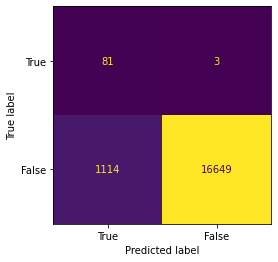

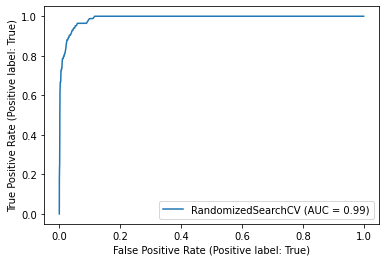

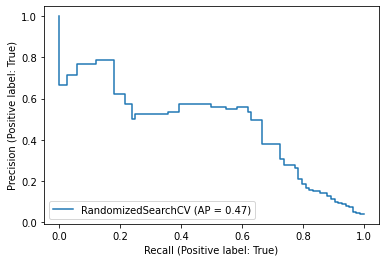

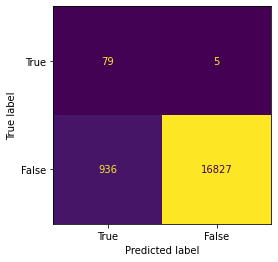

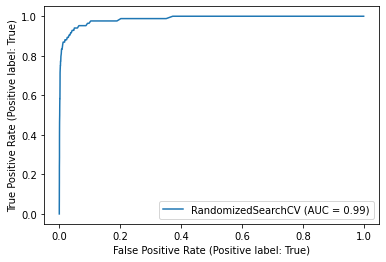

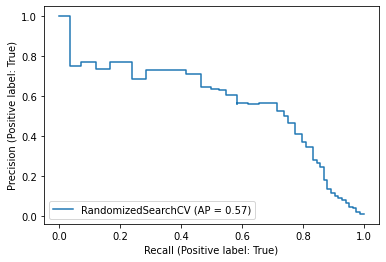

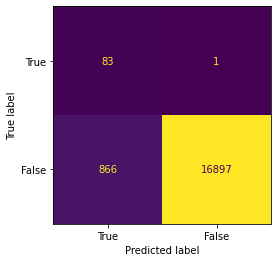

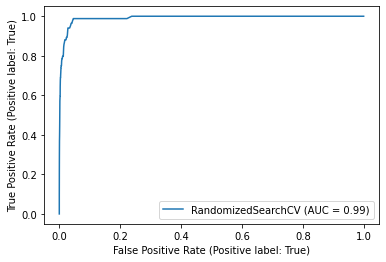

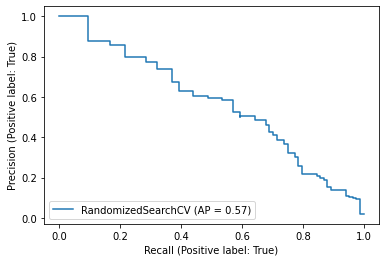

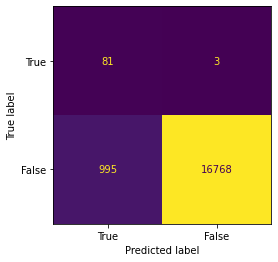

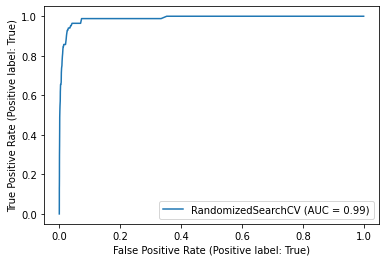

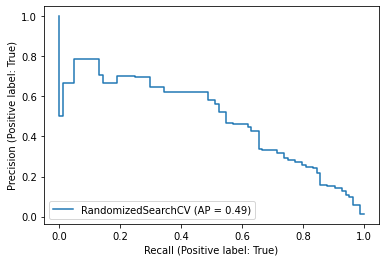

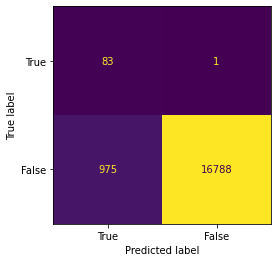

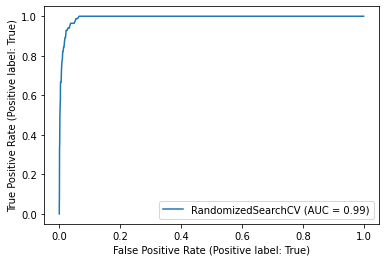

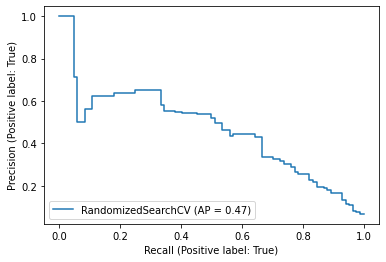

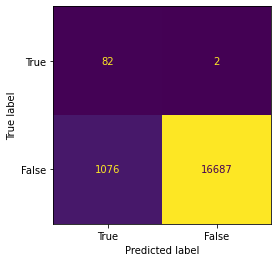

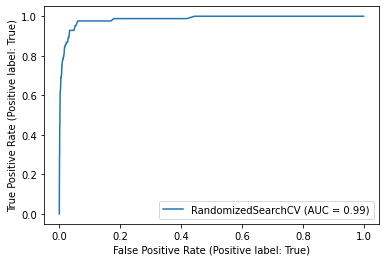

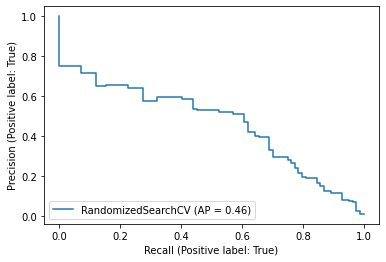

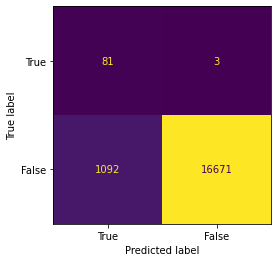

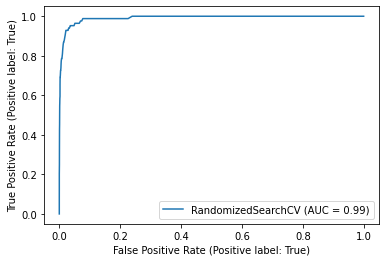

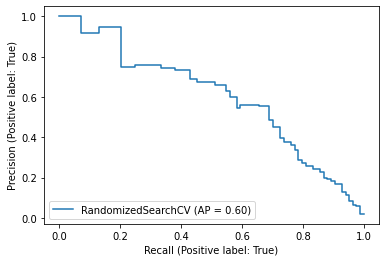

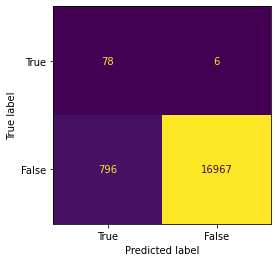

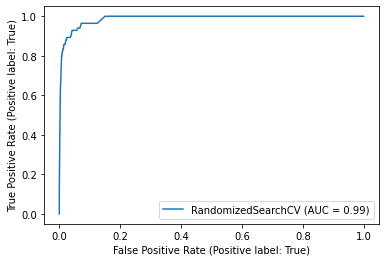

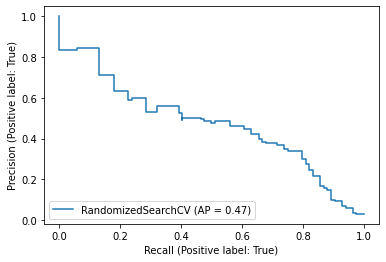

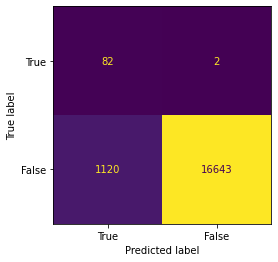

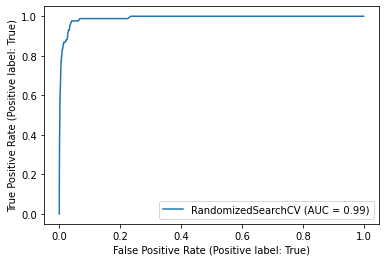

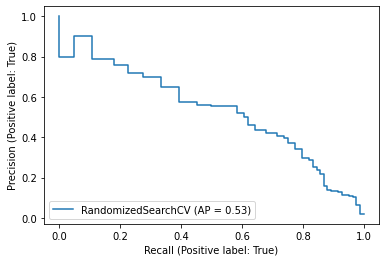

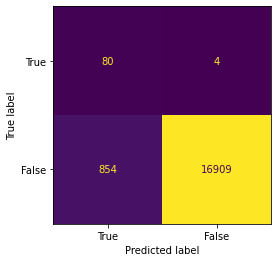

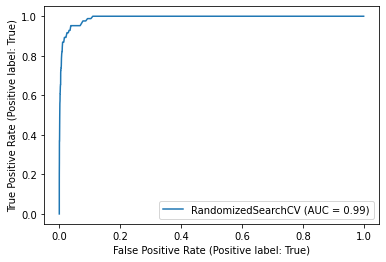

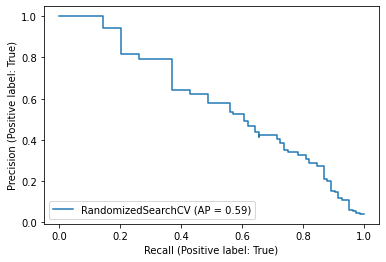

In [172]:
for i in range(10):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                              ['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    spaceEmpty = dict() 

    search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.1, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68297577 0.7070872  0.6902534  0.70067885        nan 0.67272235
 0.71003608 0.6995864  0.69177931 0.6907108  0.69624393 0.68884669
 0.69384019 0.67353051 0.69595459 0.67478447 0.68648596 0.68889065
 0.67595801 0.68060575 0.69451332 0.6875666  0.65792997        nan
 0.69255171 0.70086335 0.68646718 0.70532107 0.66300986 0.69015673
 0.66739935 0.69963909 0.68326706 0.67244327 0.70288865 0.6652322
 0.67914238 0.6967347  0.69679299 0.69703733 0.71704419 0.6993259
 0.71197632 0.6939532  0.67382878 0.70141993 0.69873272 0.72060604
 0.70059192 0.6967645  0.70816567 0.68042097        nan 0.68585116
 0.70377036 0.67430718 0.66736898 0.67686825 0.70804128 0.69844583
 0.72506206 0.68706062 0.70112406        nan        nan 0.67928848
 0.6762931         nan 0.71449655 0.66638018 0.66555154 0.70665307
 0.71527125 0.71016168 0.68656781 0.70105346 0.66791836 0.68548441
 

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 2687.959 seconds
Cross-validation score: 0.7250620620312199
Test score: 0.7906976744186045
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 400, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.4}
2196.04749190266
38023.80559979397
69989.34573807556
4492.695073637296
5114.191339832207
30.43745067541022
86.8881873092032
362.9186037030886
199.16209565126337
107.3074195815716
19.30841445119586
5.493609210476279
1528.6567083400441
6770.146967894456
917.5530773010687
0.0
396.6897316031973
0.0
9.792274321254808
2.424567531910725
2534.987934880948
519.9826013748534
1618.1283240508055
13.059701621881686
51.133208651677705
1.6411661081947386
21.51153748203069
4.340046998986509
54.89720399369253
101.13570172688924
1.2345913155004382
4.741114191012457
13.611697604297

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69783989 0.69452997 0.68634695        nan 0.6967224  0.69192136
 0.69697506 0.68479258 0.70117506 0.66030793 0.67023521 0.70055456
 0.67517312 0.70027883 0.69360153 0.69618645 0.70854984 0.67916456
 0.70695069 0.69001262        nan 0.7095359  0.71063519 0.68560923
 0.70046165 0.70395914 0.69509809        nan 0.68370189 0.70141237
 0.66436021 0.64343471 0.70286882        nan        nan 0.67105726
 0.69985898 0.70357993 0.68048312 0.6953699  0.68264211 0.71351696
 0.71019272 0.71971068        nan 0.706672   0.69576377        nan
 0.71911777 0.6649405  0.68754827 0.70180185 0.68292015 0.70007135
 0.70548066 0.6835158  0.70086338 0.69230161 0.69704386 0.70069865
        nan 0.70331271 0.67561466 0.55889715 0.67255948        nan
 0.64191339        nan 0.69892567 0.7124202  0.70289948 0.71781999
        nan 0.72964425 0.68137013 0.68289299 0.70214098 0.55311416

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 2669.607 seconds
Cross-validation score: 0.7296442547320328
Test score: 0.7403189066059226
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 800, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.2}
678.4494953211397
69243.08261930756
138181.26329369005
7808.040230311453
9369.219588970765
129.38318668678403
38.51954735070467
435.7399943321943
922.9961640741676
138.31241655349731
450.09842817671597
102.30117683112621
4014.1278976928443
1107.0139519562945
519.6653215400875
0.0
208.034572401084
0.0
1850.8322916384786
9.398076394572854
4581.6353493742645
704.01605765149
4586.630247035995
38.52722012810409
2.8061312027275562
20.597538702189922
110.5278076166287
39.36790848150849
53.58715057373047
197.43451007828116
182.0316011440009
89.76729199290276
28.310300215

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72906183 0.71350955 0.68943987 0.69881253 0.73510684 0.71566276
 0.70171384 0.68733048 0.71214451 0.68503539 0.69981815 0.7155558
 0.72099497        nan 0.72755198 0.6839426  0.71084139 0.69968779
 0.69854808 0.67730126 0.68242927        nan 0.71771985 0.71871903
 0.71583869        nan 0.70266176 0.71506427 0.53927414 0.68558342
 0.66576109 0.68239585 0.70286913 0.63230273 0.70015923 0.70592467
 0.69807015 0.71464974 0.64373013        nan 0.70287602 0.71285051
 0.69179841 0.71600534 0.57304622        nan 0.72112278 0.69717857
 0.71824077 0.67424577 0.71495593 0.71405711 0.70727568 0.70205076
 0.68967007 0.72576429 0.70584972 0.71225047 0.69286698        nan
 0.6821697  0.70100277 0.67405563 0.71582178 0.68893188 0.37769543
 0.71268357 0.70671207 0.71807711 0.65215122        nan 0.70265489
 0.70346441 0.72015856 0.70992952 0.70996662 0.71099573 0.71421058


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 2674.664 seconds
Cross-validation score: 0.7351068398847046
Test score: 0.6791569086651054
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 200, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.2}
457.0297999791801
80565.44867082313
124206.06468063593
10405.481289830059
12337.256673205644
115.84724352508783
94.90954004973173
29.29667730629444
701.4838628433645
39.170495577156544
131.92161476239562
32.18627116084099
4759.619914736599
977.9867786355317
981.642529156059
0.0
990.0117797702551
0.0
231.01129093766212
158.83694349229336
6321.8824550919235
580.3405550569296
2205.978142544627
165.10420113801956
114.23027818650007
1.8305220156908035
63.43034382537007
67.46490341424942
36.19603047147393
205.0981604680419
47.82019683718681
15.60070139914751
145.352624

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70930435 0.72010701 0.68514287 0.64042779 0.6865253  0.68575245
 0.70218335 0.68669341 0.70332147 0.71248488 0.68233432 0.69930119
 0.70977996 0.71380468 0.71472758 0.69550934 0.71698272 0.70780098
 0.69177401 0.70849309 0.72286596 0.703521   0.68566924 0.70581996
 0.71300511 0.68105327 0.70858503 0.70327077        nan 0.69303845
 0.70944962 0.69495101 0.69734139        nan 0.68347873 0.71263674
 0.69630132 0.70008429 0.70321665 0.72728635 0.6746027  0.70517306
 0.69115496 0.67687319 0.70454754 0.69101179 0.71002887 0.71667253
 0.71489603 0.69714151        nan 0.70794121 0.70031168 0.67325618
 0.6977368  0.69639773 0.69390475 0.67566226 0.69669783 0.72086155
 0.69440808        nan 0.68666111 0.71033619 0.6836884  0.65922479
 0.71722259 0.68924915 0.72406534 0.67517442 0.62126733 0.69150057
 0.70624632 0.68531426 0.69505276        nan 0.68314811 0.71503854

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 2737.440 seconds
Cross-validation score: 0.7272863457746092
Test score: 0.7226107226107227
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 500, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.6}
272.2581668595376
29056.208523151174
56964.59472770628
5798.454409590857
3385.432321787026
7.735774053813657
22.095117458578898
291.755623712801
0.5558531112910714
144.86424525649636
157.42746245412854
3.054078865388874
1273.6857804395258
491.52197488020465
128.3885868427751
0.0
337.78091692598537
0.0
101.53435070290288
1.823273627931485
1990.0919472723472
102.0216957059165
1321.9076663097367
53.25806231106981
0.6244545794324949
0.3520658133784309
49.83607039414346
7.675003539538011
0.004005269962362945
105.63135749445064
0.0
1.240174954291433
1.6739278844033834


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.71633451 0.68885422 0.66851842 0.68139229 0.69784051 0.71490971
 0.66738146 0.66184116 0.71390525        nan 0.68741021 0.67389435
        nan 0.67342522 0.70986335 0.65954616 0.68326274 0.71746441
 0.66972811 0.70376528 0.67829671 0.70281192 0.7041641         nan
        nan 0.686137   0.6941213  0.68643049 0.72100965 0.71376352
 0.68981761        nan 0.633647   0.73238059 0.69669372 0.7200336
 0.72248242 0.68986754 0.70665013 0.67664462 0.71404489 0.69489886
 0.67299895 0.70506859 0.6985866  0.72081673        nan 0.69829088
 0.70702639 0.68111643 0.68568321 0.69268316 0.44455458 0.71277205
 0.70891238 0.67610881 0.69758605 0.68542907 0.70308602 0.68643117
 0.71310433 0.720418   0.67691295 0.69975007 0.69866993 0.69821254
 0.70003107 0.67678423 0.70521988 0.66502438 0.70519007 0.70236898
 0.68637274 0.69156276        nan 0.67818168        nan 0.71615358


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 2602.577 seconds
Cross-validation score: 0.7323805943949001
Test score: 0.6704545454545454
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 100, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.1}
695.2244842275977
121603.64893057686
254714.2983130738
20234.801933332114
13113.083657211842
141.5156825184822
317.10070960223675
172.41990587115288
100.4318390712142
122.08776316046715
214.0921826697886
22.537787906825542
7534.64361038222
16585.802329757556
1014.4003780335188
0.0
1700.9645563685917
0.0
282.58299737097695
67.23916639387608
8451.971032650676
5433.489869582467
12181.954331509016
178.67335744202137
22.60443154722452
13.118148572742939
136.59684740006924
278.119603343308
84.3410147355462
343.72932218853384
40.312720984220505
32.15381655469537
167.945

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.70469291 0.69186727 0.70626182 0.61706357 0.71111912
 0.69125873 0.697296   0.71022435        nan 0.716532   0.71217672
 0.70650231 0.70225929 0.7046454         nan        nan        nan
 0.69525213 0.69083697 0.67272993 0.71165656 0.7018555  0.66348831
 0.71360579 0.70651291 0.6683655  0.70604298 0.6784156  0.71345581
 0.69529795 0.70569071        nan 0.67917512 0.71193551 0.69818473
 0.71971364 0.71105343 0.69839765 0.71046686 0.67455599 0.69271776
 0.69407988 0.69634154 0.6816994         nan 0.68532716        nan
 0.70431856 0.67593104 0.67958171 0.66690618        nan 0.67134519
 0.71389092 0.68560683 0.67519153        nan 0.69269682 0.7030407
        nan 0.68510727        nan 0.65438738 0.67355078 0.68695746
 0.58687685 0.70232585 0.70437206 0.69406729 0.68676353 0.68189749
 0.72149746 0.66922116 0.70686866 0.70406392 0.69111316 0.71392336


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 2534.048 seconds
Cross-validation score: 0.7214974605208055
Test score: 0.7046979865771811
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 200, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.1}
3437.157090961933
121867.27337661386
251400.17035609484
15491.235475897789
17761.43756943941
185.6165268421173
1079.3060509562492
1021.6319434046745
123.4916900396347
340.9606238603592
700.5528683066368
24.415176153182983
4174.073461472988
29446.009189724922
1903.5149773955345
0.0
918.1448515057564
0.0
147.36630630493164
67.43051117658615
6302.038961291313
837.3573449850082
7283.77794072032
162.65465635061264
18.198578119277954
62.72155803442001
1020.1190006732941
198.48235926032066
31.784175395965576
254.6589633822441
5.459249973297119
96.30201780796051
65.75352

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6567885  0.66533346 0.6961277  0.68037028 0.70320891 0.63642816
 0.69160513 0.70596867 0.70687394 0.70710327 0.66321961 0.70249459
        nan 0.70110328 0.66403338 0.6934991         nan 0.6550584
 0.67320574 0.68109568 0.69444324 0.7016452  0.67761565 0.70730018
 0.70622839        nan 0.6819821  0.71303375 0.4211817  0.69626242
 0.70430666 0.65231487 0.69667281 0.69616483 0.69756355 0.68968303
        nan 0.67837366        nan 0.67066572 0.70439196 0.68398933
 0.70077311 0.6857237  0.6981996  0.69872635 0.69526481 0.67670189
 0.70806233 0.68748401 0.70740363 0.70067978 0.67637882 0.68041451
 0.69032413 0.6923131  0.68472717 0.67990677 0.68109335 0.69496013
 0.63015628 0.69728301 0.69758885 0.69211311 0.7243224  0.69990914
 0.69939785 0.69264655 0.67747354 0.69527689 0.54530879 0.69784281
 0.66920295 0.69340535 0.71232389 0.69180731 0.69088389 0.68809308


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 2734.987 seconds
Cross-validation score: 0.7243223971356091
Test score: 0.735981308411215
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': -1, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.3}
413.8283134378871
57307.25539839723
88119.071217392
4118.2903513449855
9530.83565920197
140.2670430445578
66.8832563917531
16.51430167176295
62.30265025928384
210.26155167352408
220.17922584427288
42.64288520583068
1881.4146870602417
968.2997781183512
1598.6235534219704
0.0
371.24931822367944
0.0
98.18953175895149
8.889567683741916
4412.789726242001
458.8385886588949
1426.548506746156
377.1287816213153
12.558102532668272
0.12388462363742292
68.56052738633298
219.38289099238318
93.97754878629348
29.855456341872923
5.464731166983256
3.454934522509575
6.81455461334553

C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68854732 0.69443041 0.65174405        nan 0.67383768 0.67543364
 0.68447977 0.6867129  0.67491092 0.6924119  0.65775725 0.68185982
 0.69725329        nan 0.69680414 0.66001436 0.69571429 0.7002842
 0.69824626 0.69095438 0.67791453 0.68585098 0.71870744 0.67088258
 0.67488802 0.67703422 0.65944306 0.65812488 0.68606242 0.68529155
 0.55773516        nan 0.65601275 0.66993443 0.68703015 0.68229974
 0.69977531 0.67641528        nan 0.69153645        nan 0.70152757
 0.68918555 0.65866069 

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 2624.057 seconds
Cross-validation score: 0.7187074439428669
Test score: 0.8120649651972158
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 900, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.3}
1228.967259293422
48222.77905859379
89191.18322595814
5529.925304084085
7928.281654235441
143.60403836984187
36.7191706802696
408.122421445325
287.1554057719186
67.19690243527293
21.445560310035944
3.49970449693501
1656.9286546539515
6043.55612950027
1535.9048242466524
0.0
415.25034125335515
0.0
5.956311867572367
34.806309431791306
3093.8684742189944
640.0526836412027
3515.3733179541305
74.3168314397335
7.129441878758371
5.018455620855093
16.759762068279088
44.50128844752908
46.44612258672714
217.57354907877743
5.429420202970505
7.000125393271446
231.490849482826

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69697654 0.70446999        nan 0.717199   0.70871891 0.71610694
        nan 0.70220375 0.70366705 0.71195104 0.71691173 0.72665735
 0.7012206  0.71416057 0.69139153 0.69127512 0.70390653 0.69048985
        nan 0.70747346 0.72562849 0.68970999 0.71045582 0.67979713
 0.7087176  0.69257654 0.72296211 0.68217452 0.70606671        nan
 0.70903926 0.70844265        nan 0.70546865 0.71018466 0.68555741
 0.66767102 0.70297956 0.71412673 0.69330834 0.64785454 0.68029309
 0.69838749 0.66059915 0.69911446 0.7203246  0.72526922 0.72256997
        nan 0.69680624 0.70319701 0.70386473 0.69443204 0.71415093
 0.67554748 0.68953187        nan 0.6833728  0.70536759 0.66856071
 0.68930417        nan 0.70038723        nan 0.67515315 0.71483682
 0.72050904 0.68298444 0.70481892 0.68716936        nan 0.68876541
 0.71201919 0.67029569 0.70748823 0.71244091 0.6815395  0.68810778

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 2564.892 seconds
Cross-validation score: 0.7266573508956438
Test score: 0.715962441314554
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 600, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.7}
673.0752317130355
28650.283109969878
46410.9704118137
3082.9647570959933
6148.872097301721
19.532185748018946
429.71148035003625
37.899251517308585
6.556185049354099
122.69431814691052
67.51029564559576
54.94217990488687
1902.3848355520036
351.9705972510887
150.03275745245628
0.0
134.9561751802721
0.0
43.145578966663834
23.496378407930024
2212.488461686946
24.915177502378356
2043.1930590980992
60.27663810593731
8.654204985756223
10.417421622289112
373.0793409123944
35.05916730537865
2.1840857616625726
20.14138288619506
1.4601098872954026
1.696560025215149
7.314030

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73049925 0.73192272 0.71795702 0.72781636 0.73910606 0.72314024
 0.69755036 0.7359205  0.71531209 0.71600062 0.7344123  0.72269397
 0.70206099 0.70668684 0.72068734 0.70312877 0.70745585 0.72655407
 0.7076232  0.72866514 0.69652483 0.72848735 0.7350544  0.73059427
 0.68160477 0.7079944  0.71433043 0.71127745 0.71072852 0.71765119
 0.72540665 0.74627939 0.72461726 0.72602409 0.73255239        nan
 0.69559399 0.73864564 0.74161901 0.71031761 0.72057421 0.72058009
        nan 0.73226396 0.71922266 0.68772701 0.72063906 0.70467506
 0.70435517        nan 0.70968232 0.71424982 0.71492009 0.5349443
        nan 0.72162081 0.70203108 0.68486338        nan 0.71208823
 0.72235747 0.70653666 0.68469366 0.72630949 0.70551955 0.6661502
 0.70554912 0.73145889        nan        nan 0.70559383 0.69863847
 0.74487261 0.73042855 0.70373415 0.72213394 0.73723833 0.72351304
 

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 2720.388 seconds
Cross-validation score: 0.7474759814747316
Test score: 0.677570093457944
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 600, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.2}
841.6579804951325
82948.39253931027
123253.1306283134
5450.034725562669
13016.271021485329
301.5312359156087
192.02435759082437
101.65743930265307
180.14639737736434
145.8588640987873
355.52122323587537
2.238706946372986
3636.2307055760175
1341.854316521436
1286.4293883685023
0.0
1453.165555733256
0.0
43.423010625876486
1.9963512122631073
3545.4002983476967
1154.9030969664454
3480.5965540921316
42.828581346198916
141.97700143978
15.2760686064139
51.44557936023921
97.3801225265488
17.237899780273438
11.1927948333323
39.445631025359035
30.803283317014575
316.8079989

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73037777 0.71230079        nan 0.69138432        nan 0.71936623
 0.70726119 0.67833694 0.70800975 0.71858554 0.72072015 0.65771346
 0.73995649 0.71828285 0.72572986 0.68081345        nan 0.74063578
 0.71033003 0.69795819 0.71478156 0.70529773        nan 0.69596833
 0.7146495  0.71960191 0.69118355 0.71691608 0.69001343 0.71334659
 0.70927855 0.71039466 0.69457815 0.73438817 0.70559136 0.73386401
 0.7047916  0.7081628  0.70591662 0.71971848 0.72193949 0.7157196
 0.72041396 0.71632457 0.71364267 0.72249653 0.71288019 0.69410287
 0.68582989        nan 0.73646455 0.66193911 0.73043276        nan
 0.70897096 0.54159705 0.69895902 0.72467164        nan        nan
 0.37700709 0.71821119 0.70590551 0.70750003 0.71211206 0.6911639
 0.71850259 0.70719401 0.73236913 0.71853959 0.70686696 0.71767069
 0.71242599 0.72754997 0.70734674 0.72975816 0.71717734 0.73523571
 

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 2585.325 seconds
Cross-validation score: 0.742692228061928
Test score: 0.689252336448598
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 700, 'classifier__max_bin': 200, 'classifier__learning_rate': 0.2}
1170.6611033584923
66255.03942344338
126586.37797360495
11254.527718696743
8874.279569708742
4163.735498713795
44.1547455615364
72.87604149244726
74.52301971800625
90.27502967463806
566.5325732752681
41.93519973754883
2360.3223012015224
9216.444253898982
393.8370919339359
0.0
280.9371314384043
0.0
417.06168879568577
22.611516365781426
4820.563250280917
2357.760825790465
5294.891461951658
52.9518956951797
64.67973698675632
37.936225943267345
110.115807171911
128.52812853828073
18.795830488204956
298.30781980603933
17.143281809985638
40.6837013065815
32.2547920495271

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.71380869        nan 0.72210595 0.69896606        nan 0.74607606
 0.70606955 0.71867997 0.69691602 0.7062967  0.68958964 0.73558772
        nan 0.72334824 0.7102865  0.72201024 0.7040321  0.71843835
 0.73227025 0.72947647 0.70689557 0.69321998 0.72987692 0.70465298
 0.72975699        nan 0.70883337 0.65682754 0.70922759 0.70224153
 0.69344738 0.67303597 0.70297582 0.70943985 0.71305405 0.71452559
 0.71706734 0.69596721 0.74060608 0.69175792 0.71831673 0.70112448
 0.69496935 0.72810712 0.72355086 0.74012294 0.73321169 0.70530519
 0.71599845 0.71527419 0.7024267  0.7160735  0.71405687 0.70611923
 0.73927187        nan 0.65012814 0.71746391 0.72914938        nan
 0.73043663 0.72894422 0.69122529 0.71176558 0.7191539         nan
 0.73215115 0.71998597 0.69958962 0.73296845 0.70972557 0.71020487
 0.71233192 0.73403504 0.70623705 0.72509474 0.69168427 0.73899137

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 2579.318 seconds
Cross-validation score: 0.7460760580316892
Test score: 0.6462585034013606
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 600, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.2}
884.1054076272994
60238.38809027523
129634.66000202484
10098.797107478604
13505.719076925889
39.826024727895856
362.2536495067179
114.59626299515367
57.0435541421175
68.6271635144949
279.67489939182997
17.60138066112995
3759.7456336058676
8618.787336431444
390.57347859069705
0.0
1056.869659891352
0.0
76.72666406072676
29.53276041895151
6498.931826047599
1137.224170729518
6722.661491759121
58.52718531899154
39.98257990553975
49.28325057961047
34.17145853675902
133.25705209746957
178.477963604033
171.91393184289336
103.7274118848145
0.8436819911003113
33.5806108079

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69495527 0.6977501  0.68037614 0.70011007 0.70102364 0.67921885
 0.70963898 0.69668749 0.68928736 0.71500199 0.7078955  0.69970539
 0.69801504 0.69683041 0.7089382  0.67565386 0.70069032 0.68798737
 0.69210191 0.70324716 0.7082359  0.72031408 0.69811714        nan
 0.68515522 0.70151179 0.68599875 0.70022243 0.71014758 0.66840651
 0.68601085 0.68706485        nan 0.70231824        nan 0.7063189
 0.67996593        nan 0.71596351 0.68763553 0.69498606 0.71915751
        nan 0.66618526        nan 0.70841053 0.68142907 0.69745852
 0.69387968 0.68639212 0.70428559 0.65701739 0.70267658 0.71994995
 0.71095415 0.67609483 0.65189345 0.69173656 0.6744859  0.68037708
 0.70581985 0.70844075 0.69332169 0.70071286 0.71941852        nan
 0.69856353 0.67527883 0.68013088 0.70674861 0.71590671 0.70719294
 0.72165056 0.7094391  0.68857449 0.68621896 0.70467803 0.67597237


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 2711.078 seconds
Cross-validation score: 0.7251590772785417
Test score: 0.6995412844036697
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 300, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.2}
892.5805042237043
68909.4268913269
134876.18616996706
7438.229486554861
13859.07509534061
47.8115953207016
477.12428694963455
245.5804106593132
126.77127599716187
409.99160169065
175.5151962041855
212.8798758983612
2852.4462116211653
1301.6792849600315
564.637135848403
0.0
330.87427005171776
0.0
44.67707446217537
15.761963874101639
4732.605185121298
198.967964053154
5173.774984896183
1355.178129196167
100.56432861089706
18.5839025080204
147.71627697348595
19.498939409852028
1.745519995689392
60.31993709504604
4.175220012664795
2.013093054294586
49.67146906256676


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.71150013 0.69325555 0.7127057  0.72317388 0.70951186
 0.69116757 0.68618057 0.68553848 0.7196361  0.69725539 0.72201959
 0.69630324 0.67383117 0.71496377 0.6921682  0.69702087 0.70414873
 0.70114233 0.70743783        nan 0.72421443 0.70136909 0.72183391
        nan 0.69830177        nan 0.69234938 0.69406264 0.72114494
 0.68289374 0.6840378  0.69110203 0.69031704 0.69682712 0.67759753
 0.69166459 0.68032648 0.70031959 0.7034171  0.69678842 0.69736395
 0.69407568 0.69335649 0.71197431 0.70589653 0.69284906 0.70204306
 0.71081177 0.68905275 0.71000528        nan 0.6939918  0.69358713
 0.68013758 0.51399656        nan 0.72327573 0.70144156 0.73233256
 0.70282527 0.69754698        nan 0.70020094 0.7074618  0.69524876
 0.69928134 0.69824558 0.66775911 0.71332548 0.45329248 0.69267411
 0.68806165 0.69574241        nan 0.71987922        nan 0.70650159

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 2675.702 seconds
Cross-validation score: 0.7323325610916503
Test score: 0.735632183908046
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 100, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.5}
329.1118874625972
39270.302474211894
57804.99784048047
2965.649667116493
6787.669854602849
26.75892326673784
39.360449923493434
153.44472511891217
602.5983361164108
4.365123524563387
18.80323634049273
16.90893845364917
2695.1522732450103
1193.7272941483534
152.33252953671035
0.0
178.27846996292647
0.0
16.242657181894174
0.21074248249351513
1800.1760790598128
348.1322010294971
1650.8060646768863
428.5488922564982
1.4262600792571902
0.14618200244149193
16.386694386135787
32.90609848606982
7.308260711259209
4.438157023338135
3.551884311294998
127.70171004283475
10.95

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67342083 0.67381675 0.68167343 0.72140445 0.69296596 0.676953
 0.63396252 0.68185531 0.65576105 0.70763074 0.70433433 0.70522367
        nan 0.68991311 0.69850637 0.67524825        nan 0.69259772
 0.66510946 0.70743993 0.69631582 0.69466163 0.69279679 0.68999661
        nan 0.69809127 0.7060986  0.69367135 0.66853653 0.70618949
        nan 0.69488118 0.50111195 0.70883976 0.70148942 0.69383295
 0.69146585 0.68386654 0.69480136 0.6930482  0.69323632 0.70214
 0.70667896 0.70255572 0.69088558 0.69893513 0.68969067        nan
 0.69928547 0.6871837  0.70689654 0.69063713 0.68282151 0.68094035
 0.65294976 0.68493833 0.71357475 0.70540964 0.71329035 0.65560246
 0.6753594  0.67548593 0.68905674 0.68201876 0.69256402 0.68571281
 0.69647119 0.67534124 0.70224426 0.67725447 0.67678009 0.69190281
 0.70635935 0.68769798 0.69771767 0.68552372 0.7039691  0.71064895
 0.7

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 2782.423 seconds
Cross-validation score: 0.7214044486377807
Test score: 0.7193396226415095
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 600, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.4}
1339.7211660722678
41153.70298265395
70193.15775384604
4475.090241037862
10479.666785648835
193.43026811489835
45.38888264085108
58.663234777748585
331.60755629495543
22.44901220497559
19.054934107567533
12.206566962529905
2121.935077688133
609.242901739286
997.7071064298652
0.0
467.98554466012865
0.0
9.404703501408221
5.948991832679894
3116.965064015909
410.0122010820487
664.7469515310513
4.36610682047467
0.19303168005717453
3.6520881000033114
43.992714127118234
50.09391392037651
15.417555426072795
140.77868089805997
2.4079726856725756
1.6174038855242543
8.89005

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70419559 0.68531803 0.67189647 0.67889053 0.69510041        nan
 0.68761103 0.68648557 0.70243946 0.67068194 0.65907615 0.7012704
 0.68557199 0.68427264 0.68280902 0.67907049 0.64144194        nan
 0.68850217 0.69661682 0.6821778  0.53205627 0.71194425 0.69452263
 0.69069182 0.68486182 0.69288511 0.7051447  0.70260396 0.69585241
        nan 0.68321018 0.69521892 0.67409992 0.67299676 0.70361306
 0.67779455 0.67749917 0.69006975        nan 0.70720189 0.68124429
 0.69527739 0.71269411 0.67237344 0.69708522 0.69277739        nan
 0.69674678 0.68820418 0.67438872 0.65695278 0.70207829 0.69950893
 0.69452976        nan        nan 0.66533957 0.70097738 0.67351163
        nan 0.68729379 0.69760933 0.67839293        nan 0.6869507
 0.70562248 0.67026739 0.71139287 0.65870474 0.69812499        nan
 0.69700752 0.70684103 0.68787876 0.68455196 0.69529143 0.70985469
 

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 2716.071 seconds
Cross-validation score: 0.7171065969197247
Test score: 0.6787330316742081
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 200, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.2}
605.9723591804504
68467.95384541154
136346.5256537199
12355.050455868244
5416.961300730705
85.91336280107498
17.292160153388977
79.81805169582367
103.89213764667511
461.6405483484268
398.4316586256027
1.7514599561691284
5230.248748898506
2132.2124651670456
644.5701540708542
0.0
914.4016733765602
0.0
1579.5370569825172
4.549544036388397
5543.301264166832
1836.963796377182
2579.6892763972282
652.9516904354095
1.0776100158691406
0.8026689887046814
15.248869895935059
96.39701175689697
91.74294078350067
111.38044238090515
4.097879886627197
3.937090039253235
41.9137241

KeyboardInterrupt: 

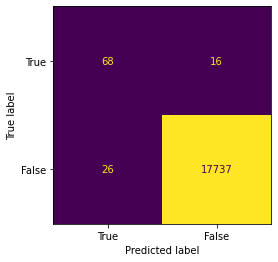

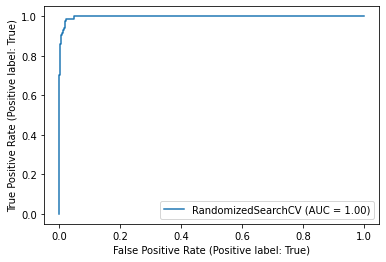

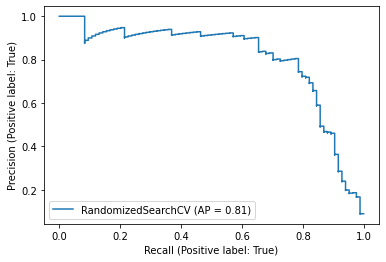

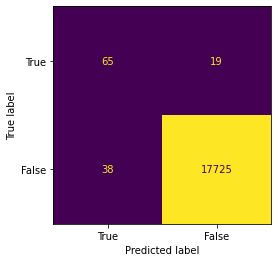

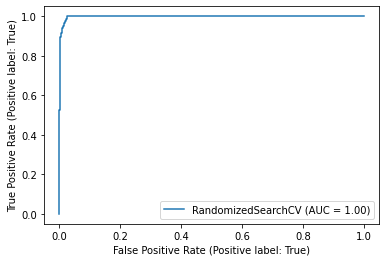

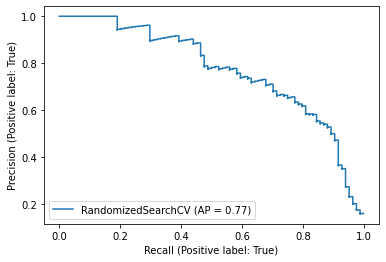

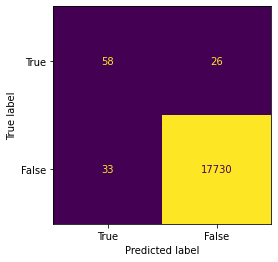

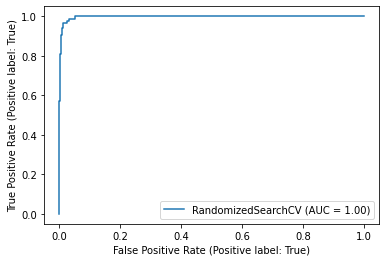

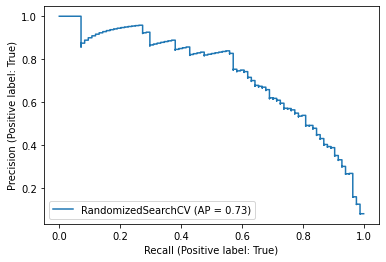

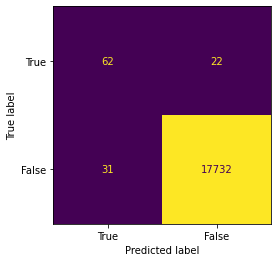

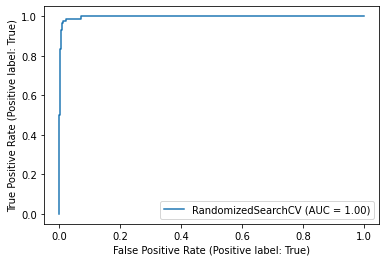

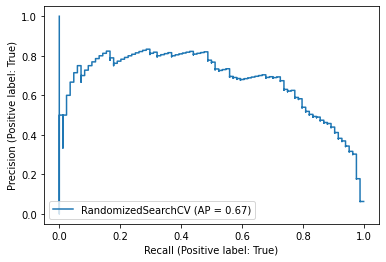

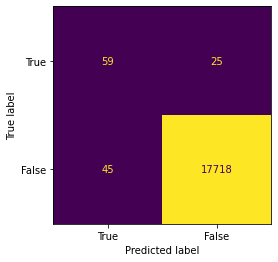

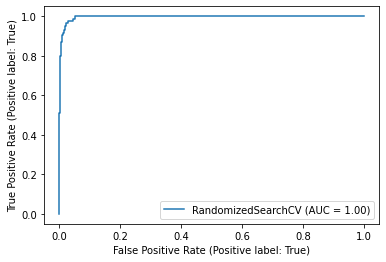

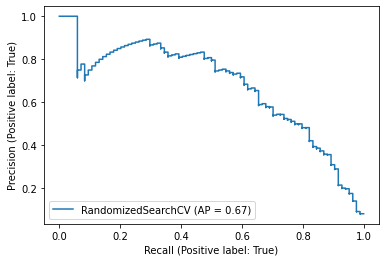

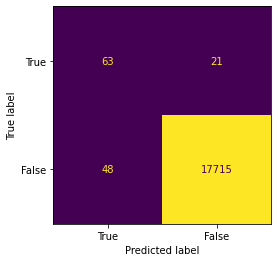

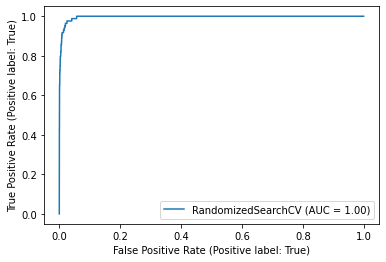

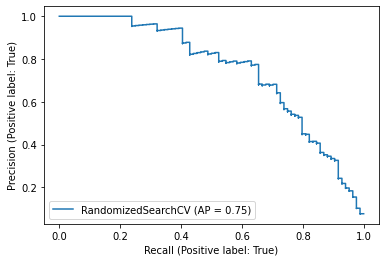

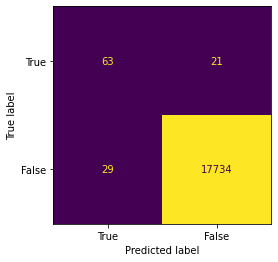

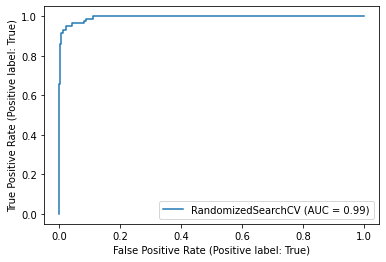

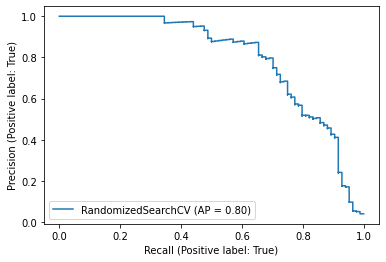

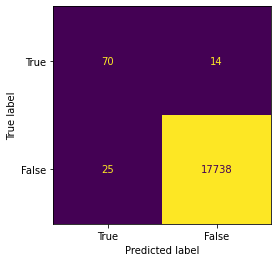

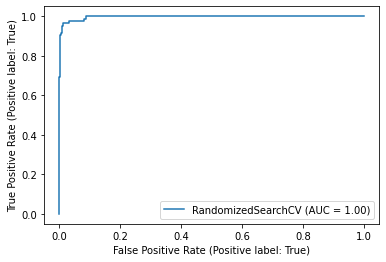

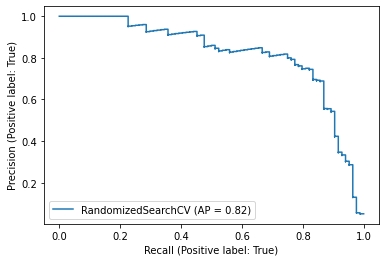

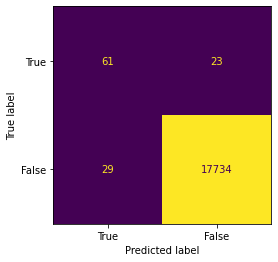

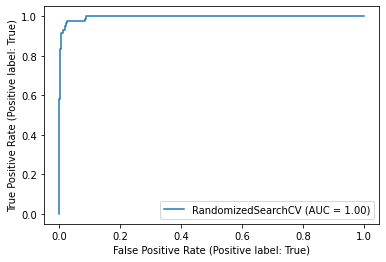

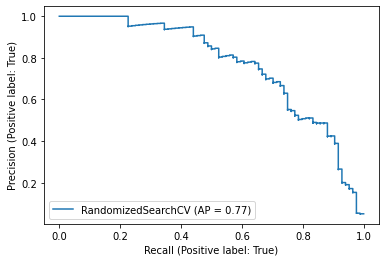

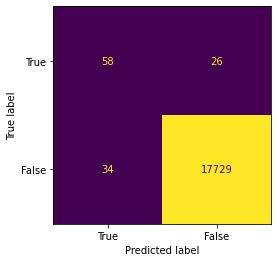

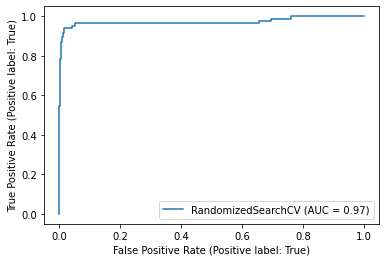

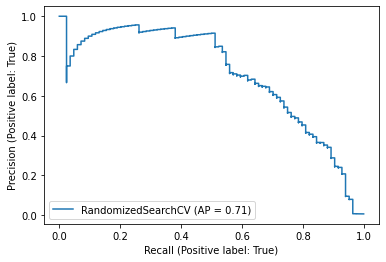

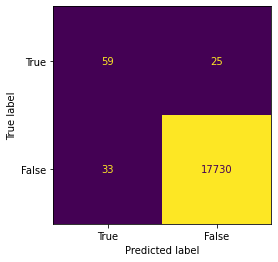

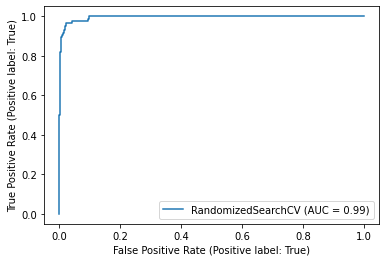

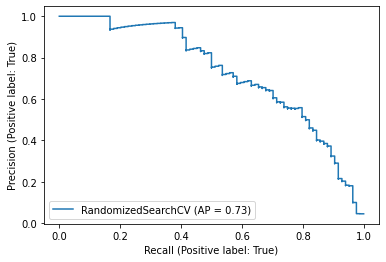

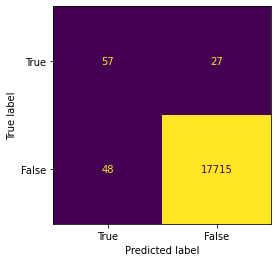

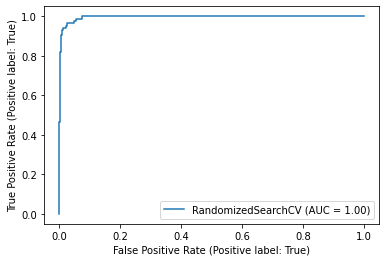

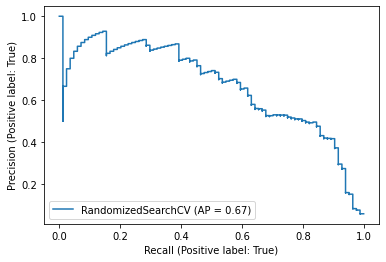

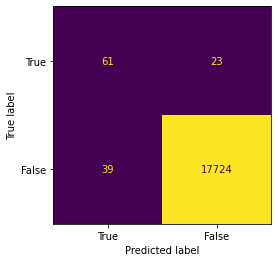

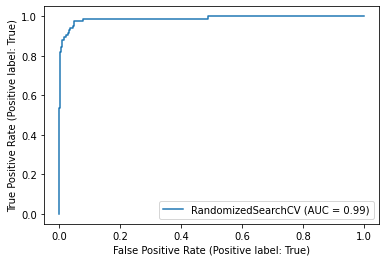

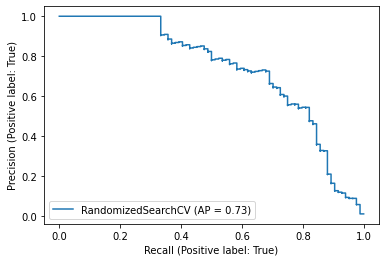

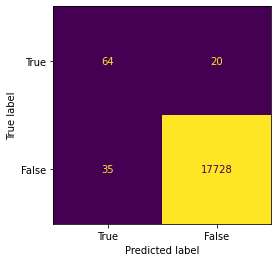

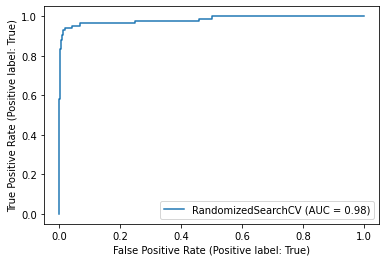

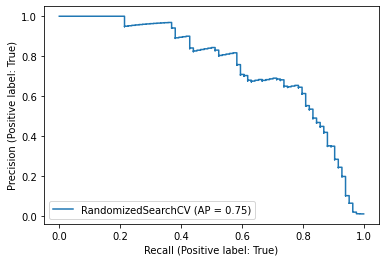

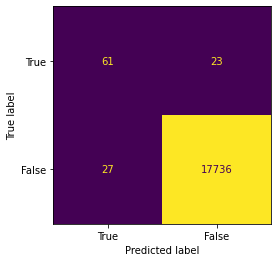

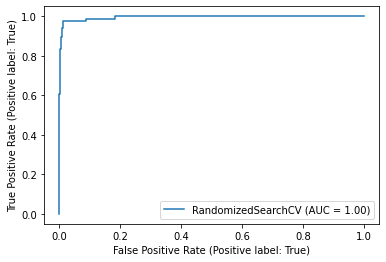

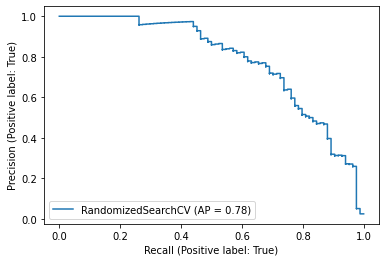

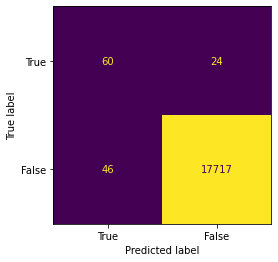

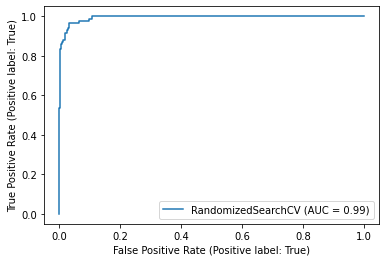

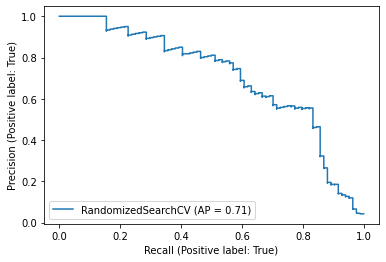

In [25]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

for i in range(25):

    ftwo_scorer = make_scorer(fbeta_score, beta=2)

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

     # define search space
    space = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]
    spaceEmpty = dict()

    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)